# Using LASSO-CACTI Data, Part 2: Animation of a Cross Section

**Author:** William.Gustafson@pnnl.gov  
**Date:** 3-May-2024  

Plotting vertical cross sections involves dealing with vertical coordinate systems, which can vary beteween models and post-processed datasets. For example, LASSO-CACTI includes terrain-following data on raw model levles plus ineterpolated data on pressure and height levels.

**Objectives of this notebook:**
1. Learn about how to work with the vertical coordinates by plotting a cross section
2. Learn about efficient animation creation within matplotlib

In [4]:
# Libraries required for this tutorial...

from datetime import datetime, timedelta
from functools import partial
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize

First, we need to make a few choices regarding what to plot.

In [5]:
# User settings...

# Case date and times to plot:
case_date = datetime(2019, 1, 29)
single_time = case_date + timedelta(hours=20, minutes=15)  # time for single-time plots
time_start = case_date + timedelta(hours=18)  # start and end times for animation
time_end = case_date + timedelta(hours=24)

# Simulation selection within the case date:
ens_name = "eda09"
config_label = "base"
domain = 2

# Cross section details:
plot_lat = -(32.+(7./60.)+(35.076/3600.))  # latitude to sample
max_hamsl = 11000  # maximum height to plot

# Other details:
rootpath_wrf = "/gpfs/wolf2/arm/cli120/world-shared/d3m088/cacti/staged_runs"
path_out = "."  # path to save animation file


## Read the data for plotting a single time

First, we will do the quick-and-dirty approach that is good for quick looks. For kicks, let's compare how this comes out for data on the raw model levels versus interpolate height levels.
We will first just look at a single time to get an idea of how the cross section plots work for different level types.

In [6]:
# Grab data for a single time to play with examples at this point...

# We will pull data for the terrain height from the static file a single time since it is constant.
# We will use the appropriate subset file for the desired plotting variable.


# Get the WRF path and open the file...
# This assumes the file folder structure used on ARM's cumulus cluster with data organized in a tree structure by  
# date / ensemble member / configuration label / scale (meso or LES) / and file type.
scale = "meso" if domain < 3 else "les"
path_wrf_subset = f"{rootpath_wrf}/{case_date:%Y%m%d}/{ens_name}/{config_label}/{scale}/subset_d{domain}"

# ...a static file for the constant information like terrain height
filename_wrf = f"{path_wrf_subset}/corlasso_stat_{case_date:%Y%m%d}00{ens_name}d{domain}_{config_label}_M1.m1.{single_time:%Y%m%d.%H%M}00.nc"
ds_stat = xr.open_dataset(filename_wrf)

# ...a meteorology state file, which we need for the height of each grid cell on raw model levels
filename_wrf = f"{path_wrf_subset}/corlasso_met_{case_date:%Y%m%d}00{ens_name}d{domain}_{config_label}_M1.m1.{single_time:%Y%m%d.%H%M}00.nc"
ds_met = xr.open_dataset(filename_wrf)

# ...a cloud subset on raw model levels
filename_wrf = f"{path_wrf_subset}/corlasso_cld_{case_date:%Y%m%d}00{ens_name}d{domain}_{config_label}_M1.m1.{single_time:%Y%m%d.%H%M}00.nc"
ds_cld = xr.open_dataset(filename_wrf)

# ...a cloud subset height-above-mean-sea-level levels
filename_wrf = f"{path_wrf_subset}/corlasso_cldhamsl_{case_date:%Y%m%d}00{ens_name}d{domain}_{config_label}_M1.m1.{single_time:%Y%m%d.%H%M}00.nc"
ds_cldhamsl = xr.open_dataset(filename_wrf)

# Next, we have to figure out which j-index to sample for the desired latitude. WRF's coordinate name for this dimension is south_north.
# We will ignore the map projection and pull along a single j index, which we will determine from the middle of the grid.
lats = ds_stat["XLAT"]
lons = ds_stat["XLONG"]
nlat, nlon = lons.shape
abslat = np.abs(lats.isel(west_east=int(nlon/2)) - plot_lat)
jloc = np.argmin(abslat.values)
lonslice = lons.isel(south_north=jloc)

# Select the specific variables used for plotting...

# Note that we do not worry about parsing the time for the terrain height
# since it is constant in time (in a static file). In theory, we could also
# do this for var_name, but if we ever combine times into one file, it could
# cause trouble, so we do a specific time selection for var_name.

# ...get the coordinate information first, which we will subset for the the cross-section swath
hgt = ds_stat["HGT"].isel(Time=0, south_north=jloc)  # terrain height along the cross section's swath
hamsl_raw = ds_met['HAMSL'].sel(Time=np.datetime64(f"{single_time:%Y-%m-%d %H:%M:%S}"), south_north=jloc)  # height of each grid cell on the raw model levels
hamsl_hamsl = ds_cldhamsl["HAMSL"]  # height of each grid cell in the HAMSL file (constant in space, so no need to subset j index)

# ...and now the data we actually want to plot, which is clouds
# We'll pull both on raw model levels and on the interpolated HAMSL, so we have everything we need for our examples.
plotdata_raw = 1000.*(
    ds_cld['QCLOUD'].sel(Time=np.datetime64(f"{single_time:%Y-%m-%d %H:%M:%S}"), south_north=jloc) +
    ds_cld['QICE'].sel(Time=np.datetime64(f"{single_time:%Y-%m-%d %H:%M:%S}"), south_north=jloc)  
    )  # cloud water+ice mixing ratio converted go g/kg
plotdata_hamsl = 1000.*(
    ds_cldhamsl['QCLOUD'].sel(Time=np.datetime64(f"{single_time:%Y-%m-%d %H:%M:%S}"), south_north=jloc) +
    ds_cldhamsl['QICE'].sel(Time=np.datetime64(f"{single_time:%Y-%m-%d %H:%M:%S}"), south_north=jloc)  
    )  # cloud water+ice mixing ratio converted go g/kg


## WRF Model Levels

Before embarking on plotting the model output, we need to understand the WRF model's vertical coordinate. Full details are at https://www2.mmm.ucar.edu/wrf/users/wrf_users_guide/build/html/dynamics.html. For our purposes here, the important thing to know is that the WRF configuration for LASSO-CACTI (and most modern WRF runs) uses a hybrid coordinate system that is 1) terrain following, and 2) hybrid in that it combines pressure-level and terrain-following levels, with stronger terrain-following weigting in the lower atmosphere.

What does this look like? Here is a plot showing the level surfaces every 10 levels from LASSO-CACTI model output.

/tmp/ipykernel_140588/3664029909.py:6: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm = ax.pcolormesh(lonslice.values, hamsl_xz.values, hamsl_xz.values,


Text(0, 0.5, 'HAMLS (m)')

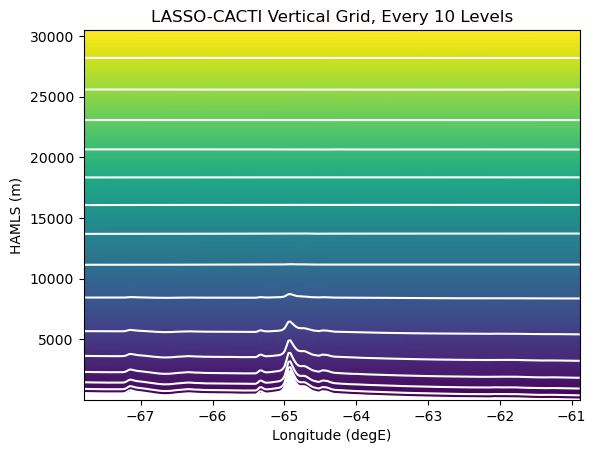

In [27]:
# Plot the raw model levels...

fig, ax = plt.subplots(1, 1)

hamsl_xz = hamsl_raw.isel(Time=0)
pcm = ax.pcolormesh(lonslice.values, hamsl_xz.values, hamsl_xz.values, 
                    shading='auto')
nk, ny = hamsl_xz.shape
dk = 10
for k in range(0, nk, dk):
    plt.plot(lonslice, hamsl_xz.isel(bottom_top=k), color="white")

ax.set_title(f"LASSO-CACTI Vertical Grid, Every {dk} Levels")
ax.set_xlabel("Longitude (degE)")
ax.set_ylabel("HAMLS (m)")

One must make choices for how to deal with the warping of level surfaces. Depending on one's needs, you have several options for how to work with the model data:

1) Ignore the warping, essentially pretending it does not exist
2) Interpolate the data to new levels based on an alternate surface; examples inlude height or pressure levels, and then plot on the new surface type
3) Keep the data in a warped space and tell the plotting software the shape of the levels

Option 1 is the quickest and easiest approach. Option 2 can be useful for reducing data if one does not need all the raw level information. Option 3 is the brute force approach, but is often the best if one has data to define the level information.

## Building up the cross-section plot

Let's build up the plot to see how data and/or plotting complexity impacts our results. 

For the first plot, we will do a quick-and-dirty plot that can be useful for quick looks (Option 1 from above). Xarray has built-in plotting capabilties that can use the coordinates and attributes associated with each variable. Since xarray cannot decipher the warped WRF grid, it treats all the levels as flat by default.

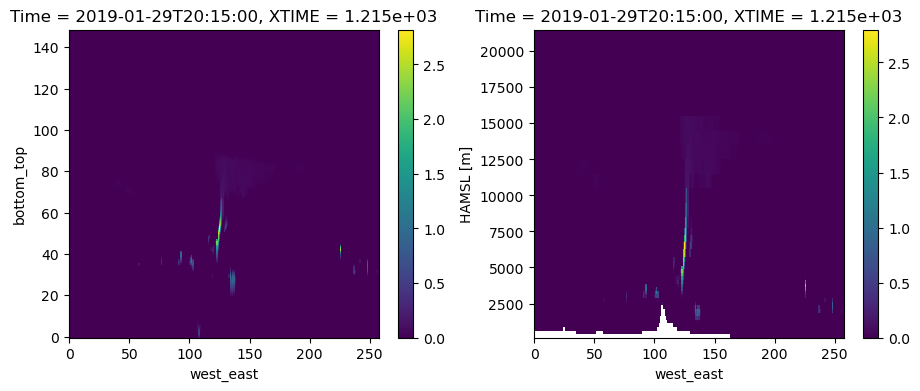

In [8]:
# Plotting version 1: A quick-look plot using xarray's defaults when reading the subset files

fig, axs = plt.subplots(ncols=2, figsize=(11, 4))

plotdata_raw.plot(ax=axs[0])  # left panel is on raw model levels -- this is Option 1 from above
plotdata_hamsl.plot(ax=axs[1])  # right panel is on HAMSL as interpolated in subset file -- this is Option 2 from above

plt.show()


The above plots are useful, but they have some limitations. For example, treating the raw model levels as flat surfaces hides the mountain. And, labeling levels by index makes it hard to really know how tall the cloud is.
The plot on the right solves these two issues, but the limited number of levels results in a blocky mountain. There was also a fair bit of effort under the hood to interpolate to HAMSL. If you were to work from raw model output, you would need to code up the interpolation in addition to the plotting. This can be a bit much for quick looks. The other limitation is that the x-axis is still in units of index, which we would prefer to be labelled as longitude.

How can we plot the raw model level information as realistic, non-flat surfaces? This is Option 3 from above. Let's do that next. We have to move beyond xarray's tools and code this using individual matplotlib routines.

/tmp/ipykernel_140588/3889244510.py:6: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm = ax.pcolormesh(lonslice.values, hamsl_raw.values, plotdata_raw.values,


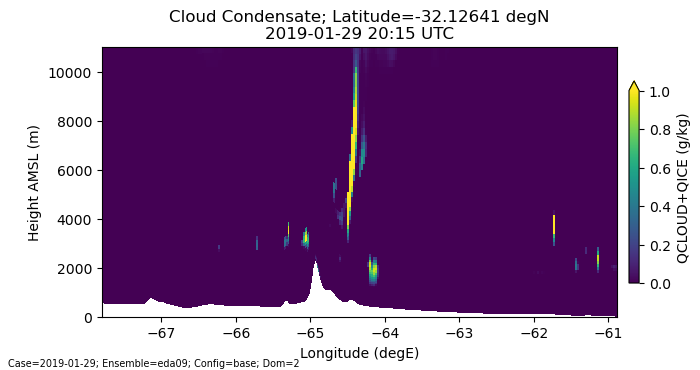

In [9]:
# Plotting version 2: Code it up yourself with bells and whistles to get full level of detail

fig, ax = plt.subplots(1, 1, figsize=[8,3.5])

# NOTE: remember we typically have to extract the values from the xarray DataArrays when passing info to matplotlib
pcm = ax.pcolormesh(lonslice.values, hamsl_raw.values, plotdata_raw.values, 
                    shading='auto', norm=Normalize(vmin=0,vmax=1))

# Add the colorbar...
cbar = plt.colorbar(pcm, ax=ax, shrink=.75, pad=0.02, extend='max')
cbar.ax.set_ylabel(f"QCLOUD+QICE (g/kg)")

# Add our labels...
ax.set_xlabel("Longitude (degE)")
ax.set_ylabel("Height AMSL (m)")
ax.set_ylim(0, max_hamsl)  # hide the model top

time_label = f"{single_time:%Y-%m-%d %H:%M} UTC"
plt.title(f"Cloud Condensate; Latitude={plot_lat} degN\n{time_label}")

run_info_label = f"Case={case_date:%Y-%m-%d}; Ensemble={ens_name}; Config={config_label}; Dom={domain}"
plt.annotate(run_info_label, (0.01,0.01), xycoords="figure fraction", fontsize='x-small')

plt.show()

## Make an animation of the cross section

The above plot is pretty good. How about animating it across time? There are two common approaches to making an animation with matplotlib. One is to plot each frame, save it as a file, and then connect the frames together into an animation using a tool like ffmpeg. This is good when you want access to single frames for later use, such as putting them in a paper or presentation. This is also embarassingly parallel, so one can use parallelization tools to speed up the plotting by spreading across cores and/or nodes. 

The second approach is to use the animation capabilities embedded within matplotlib. This is often much faster than plotting every frame inependently, as is done in the first approach. Setting up a matplotlib image has a fair amount of overhead, e.g., to determine the colors, axis limits, map projection, color bar, etc. Approach #1 has to do all this work for every frame. Approach #2 only has to do the overhead once, and then subsequent frames only need to have the new data dropped into the memory location that holds the plot details. This simple memory copy is so fast that it can often be faster to do the animation this way than in parallel. Note that the one downside of approach #2 is that it is serial since we have to work with the one spot in memory and build up the animation as we go.

Here is an example code to build an animation using approach #2.

Since we have to now read a time series of data instead of a single time, we will re-read all our data, essentially from scratch. The basic approach is the same though other than we now need to open a multi-file dataset and work with multiple times in our plotting code.

In [10]:
# Grab data for multiple times to make an animation...

# We will pull data for the terrain height from the static file a single time since it is constant.
# We will use globs to grab all the filenames of a given file type for the selected run, and then 
# we can use xarray to select the specific times and throw out the unneeded time. Alternatively, we
# could build a list of files for just the times we want, but that takes a lot more code.

# Get the WRF path and open the file...
# This assumes the file folder structure used on ARM's cumulus cluster with data organized in a tree structure by  
# date / ensemble member / configuration label / scale (meso or LES) / and file type.
scale = "meso" if domain < 3 else "les"
path_wrf_subset = f"{rootpath_wrf}/{case_date:%Y%m%d}/{ens_name}/{config_label}/{scale}/subset_d{domain}"

# ...a static file for the constant information like terrain height
filename_wrf = f"{path_wrf_subset}/corlasso_stat_{case_date:%Y%m%d}00{ens_name}d{domain}_{config_label}_M1.m1.{single_time:%Y%m%d.%H%M}00.nc"
ds_stat = xr.open_dataset(filename_wrf)

# ...a meteorology state file, which we need for the height of each grid cell on raw model levels
glob_wrf = f"{path_wrf_subset}/corlasso_met_{case_date:%Y%m%d}00{ens_name}d{domain}_{config_label}_M1.m1.*.nc"
ds_met = xr.open_mfdataset(glob_wrf)
ds_met = ds_met.sel(Time=slice(np.datetime64(f"{time_start:%Y-%m-%d %H:%M:%S}"), np.datetime64(f"{time_end:%Y-%m-%d %H:%M:%S}")))

# ...a cloud subset on raw model levels
glob_wrf = f"{path_wrf_subset}/corlasso_cld_{case_date:%Y%m%d}00{ens_name}d{domain}_{config_label}_M1.m1.*.nc"
ds_cld = xr.open_mfdataset(glob_wrf)
ds_cld = ds_cld.sel(Time=slice(np.datetime64(f"{time_start:%Y-%m-%d %H:%M:%S}"), np.datetime64(f"{time_end:%Y-%m-%d %H:%M:%S}")))

# Next, we have to figure out which j-index to sample for the desired latitude. WRF's coordinate name for this dimension is south_north.
# We will ignore the map projection and pull along a single j index, which we will determine from the middle of the grid.
lats = ds_stat["XLAT"]
lons = ds_stat["XLONG"]
nlat, nlon = lons.shape
abslat = np.abs(lats.isel(west_east=int(nlon/2)) - plot_lat)
jloc = np.argmin(abslat.values)
lonslice = lons.isel(south_north=jloc)

# Select the specific variables used for plotting...

# ...get the coordinate information first, which we will subset for the the cross-section swath
hgt = ds_stat["HGT"].isel(Time=0, south_north=jloc)  # terrain height along the cross section's swath
hamsl_raw = ds_met['HAMSL'].sel(south_north=jloc)  # height of each grid cell on the raw model levels

# ...and now the data we actually want to plot, which is clouds
plotdata_raw = 1000.*(
    ds_cld['QCLOUD'].sel(south_north=jloc) +
    ds_cld['QICE'].sel(south_north=jloc)
    )  # cloud water+ice mixing ratio converted go g/kg

Now that we have all the data available to us (either in memory or chunks of it via xarray), we can move on to making the animation.

The way matplotlib's animation routine works is to use a pre-defined subroutine that contains the instructions for what data gets overlaid when making a new frame. So, we will first define this routine, followed by the code to make the first frame, and a loop to call the subroutine for subsequent frames.

/tmp/ipykernel_140588/1988854871.py:35: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm = ax.pcolormesh(lonslice.values, hamsl_raw.isel(Time=0).values, plotdata_raw.isel(Time=0).values,


plotting frame  0
plotting frame  0
plotting frame  1
plotting frame  2
plotting frame  3
plotting frame  4
plotting frame  5
plotting frame  6
plotting frame  7
plotting frame  8
plotting frame  9
plotting frame  10
plotting frame  11
plotting frame  12
plotting frame  13
plotting frame  14
plotting frame  15
plotting frame  16
plotting frame  17
plotting frame  18
plotting frame  19
plotting frame  20
plotting frame  21
plotting frame  22
plotting frame  23
plotting frame  24
plotting frame  0


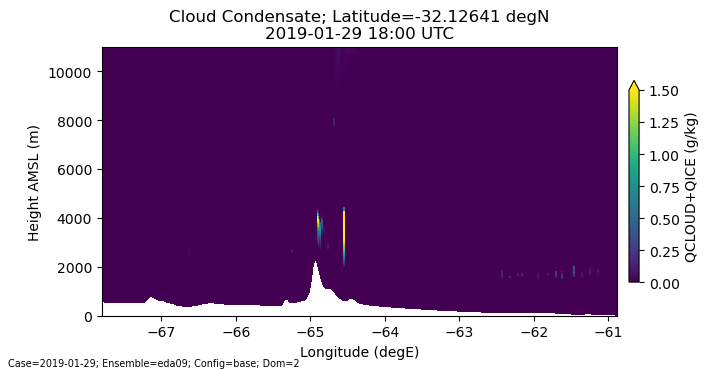

In [11]:
#-----------------------------------------------------------------------
def plot_subsequent_frame(itime, plot_lat, plotdata_raw, pcm, tx_time):
    """
    Subroutine to plot the next frame of an animation after the first frame is already defined. 
    This is to be called by animation.FuncAnimation. 
    
    Note that some data is pulled from global scope. Variables accessed from outside the subroutine:
        pcm = pcolormesh object from the initial frame
        tx_time = text annotation object for the time label from the initial frame

        plotdata_raw = variable holding the time series of data to plot
        plot_lat = latitude being plotted (needed to reconstruct the title text)
    """
    print("plotting frame ", itime)

    # Overwrite the data in memory for the values displayed in the plot...
    # NOTE: This is technically a faux paux for WRF since the model levels are not constant in time. BE CAREFUL!
    #       However, in this situation the levels are not going to change so much as to make the plot visibly change much.
    pcm.set_array(plotdata_raw.isel(Time=itime).values.ravel())

    # Update the time label...
    time_label = f"{pd.to_datetime(plotdata_raw['Time'])[itime]:%Y-%m-%d %H:%M} UTC"
    tx_time.set_text(f"Cloud Condensate; Latitude={plot_lat} degN\n{time_label}")

# end plot_subsequent_frame()


#-----------------------------------------------------------------------
# Plot the first frame of the animation...

ntimes = plotdata_raw["Time"].size
fig, ax = plt.subplots(1, 1, figsize=[8,3.5])

# NOTE: Select the first time when accessing the time series variables.
pcm = ax.pcolormesh(lonslice.values, hamsl_raw.isel(Time=0).values, plotdata_raw.isel(Time=0).values,
                    shading='auto', norm=Normalize(vmin=0,vmax=1.5))

# Add the colorbar...
cbar = plt.colorbar(pcm, ax=ax, shrink=.75, pad=0.02, extend='max')
cbar.ax.set_ylabel(f"QCLOUD+QICE (g/kg)")

# Add our labels...
ax.set_xlabel("Longitude (degE)")
ax.set_ylabel("Height AMSL (m)")
ax.set_ylim(0, max_hamsl)  # hide the model top

time_label = f"{single_time:%Y-%m-%d %H:%M} UTC"
tx_time = plt.title(f"Cloud Condensate; Latitude={plot_lat} degN\n{time_label}")

run_info_label = f"Case={case_date:%Y-%m-%d}; Ensemble={ens_name}; Config={config_label}; Dom={domain}"
plt.annotate(run_info_label, (0.01,0.01), xycoords="figure fraction", fontsize='x-small')


#-----------------------------------------------------------------------
# Now, update the underlying data in the plot for each subsequent frame...

# NOTE: See https://matplotlib.org/stable/api/_as_gen/matplotlib.animation.FuncAnimation.html for
#       explaination of how to use functools.partial for passing arguments to the redraw subroutine.
ani = animation.FuncAnimation(fig, 
                              partial(plot_subsequent_frame, plot_lat=plot_lat, plotdata_raw=plotdata_raw, pcm=pcm, tx_time=tx_time),
                              frames=range(ntimes))

# And save the results...
filename_mp4 = f"{path_out}/corlasso_anim_qci_{case_date:%Y%m%d}00{ens_name}d{domain}_{config_label}.mp4"
fps = 6 if domain < 3 else 8  # set frame rate for dt=15 vs. 5 minutes
ani.save(filename_mp4, writer=animation.FFMpegWriter(fps=fps, bitrate=5000, codec="h264"), dpi=150)